# EEG Focus vs Relaxation Classification

## Introduction
EEG (Electroencephalography) measures brain activity across different frequency bands (Delta, Theta, Alpha, Beta).  
- **Relaxed state (eyes closed):** Alpha (8–13 Hz) power increases.
- **Focused state (motor imagery):** Beta (13–30 Hz) power increases, Alpha decreases.

This project uses the **EEGBCI dataset** (PhysioNet), which contains EEG data during baseline and motor imagery tasks.  
Goal: **Classify Relaxed vs Focused mental states using band power features and Random Forest.**


## Step 1: Installing and Importing Required Libraries

We start by installing MNE, a powerful EEG/MEG data analysis library. We also import standard libraries for numerical computing, visualization, and machine learning.

- **MNE** is used to load and preprocess EEG datasets.
- **NumPy & Matplotlib** are used for basic computations and plots.
- **Scikit-learn** provides ML models and evaluation tools.
- **Seaborn** helps visualize the confusion matrix.


In [ ]:
# Install dependencies
!pip install mne numpy scipy scikit-learn matplotlib seaborn


# Imports
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf, concatenate_raws
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Step 2: Loading EEG Data

We load EEG data using `mne.datasets.eegbci.load_data()`.

We're using Subject 1 and runs 6 & 10 from the BCI Competition dataset:
- **Run 6:** Left hand motor imagery
- **Run 10:** Right hand motor imagery

We concatenate them into one continuous signal using `concatenate_raws()`, and rename EEG channels to remove dots for compatibility with MNE montages.

In [ ]:
# Subjects 1, Runs 6 & 10: Motor Imagery Left vs Right Hand
# ==========================
subject = 1
runs = [6, 10]  # 6 = left hand, 10 = right hand

mne.set_log_level('WARNING')  # Suppress warnings
files = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in files])


## Step 3: EEG Preprocessing

To ensure signal quality and consistency:
- **Montage (electrode layout):** Applied using `standard_1020`. It aligns channel names to a physical scalp map.
- **Filtering:** We apply a bandpass filter between 4–30 Hz. This range captures key motor rhythms:
  - **Mu rhythms (8–12 Hz)**
  - **Beta rhythms (13–30 Hz)**

Filtering removes slow drifts and high-frequency noise not relevant to motor imagery.


In [ ]:
# Normalize channel names (e.g., 'Fc5.' → 'FC5')
raw.rename_channels(lambda name: name.strip('.').upper())

# Set standard EEG 10-05 montage, allow missing channels
raw.set_montage('standard_1005', on_missing='ignore')

# Bandpass filter the EEG data (4–30 Hz)
raw.filter(4., 30., fir_design='firwin', skip_by_annotation='edge')



<RawEDF | S001R06.edf, 64 x 40000 (250.0 s), ~19.6 MiB, data loaded>

## Step 4: Epoching and Event Annotation

We segment the raw continuous EEG into short time-locked windows called **epochs**, around motor imagery events:
- Epochs are 1.0s long and aligned with event onsets (time 0).
- The EEG signal is **baseline-corrected** (i.e., removing mean from pre-stimulus time) to remove constant offset.

We also filter to only include **left vs right hand imagery** and reject eye artifacts using simple peak-to-peak thresholds.


In [ ]:
# Pick only EEG channels (ignores ECG, EMG, etc.)
raw.pick_types(eeg=True)

# Define events from the stimulus channel
events, _ = mne.events_from_annotations(raw)

# Define epoching parameters
event_id = dict(T1=2, T2=3)  # 2 and 3 are the motor imagery tasks (left hand, right hand)
tmin = -1  # start of each epoch (in seconds)
tmax = 4   # end of each epoch

# Extract epochs based on events
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax,
                    baseline=None, preload=True)

## Step 5: Feature Extraction using Power Spectral Density (PSD)

We compute Power Spectral Densities (PSD) to extract features:
- PSD represents how power (signal energy) is distributed across frequencies.
- We focus on 4–30 Hz, which includes motor-relevant mu and beta rhythms.

MNE computes PSD for each epoch using **multitaper spectral estimation**, a method that provides stable frequency estimates.



In [ ]:
psd = epochs.compute_psd(method='welch', fmin=4, fmax=30, n_fft=256)
psds, freqs = psd.get_data(return_freqs=True)

# Flatten the features and get labels
X = psds.mean(axis=2)  # average across frequencies
y = epochs.events[:, 2]  # labels (2 = left hand, 3 = right hand)


## Step 6: Classification using Logistic Regression

We use **logistic regression**, a simple yet effective linear model for binary classification.

Steps:
1. Flatten the PSD features.
2. Split data into training and testing sets (80/20).
3. Train the model on training data.
4. Evaluate accuracy on test data.

Logistic regression is interpretable and works well with high-dimensional EEG features.



In [ ]:
# 6. Train ML Classifier
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Left', 'Right']))


              precision    recall  f1-score   support

        Left       0.50      0.20      0.29         5
       Right       0.43      0.75      0.55         4

    accuracy                           0.44         9
   macro avg       0.46      0.47      0.42         9
weighted avg       0.47      0.44      0.40         9



## Step 7: Confusion Matrix Visualization

We plot a **confusion matrix** to visualize model performance:
- True vs predicted labels.
- Useful to identify which class (left/right) is being misclassified more often.

We use `seaborn` heatmap to generate a clean and interpretable plot.


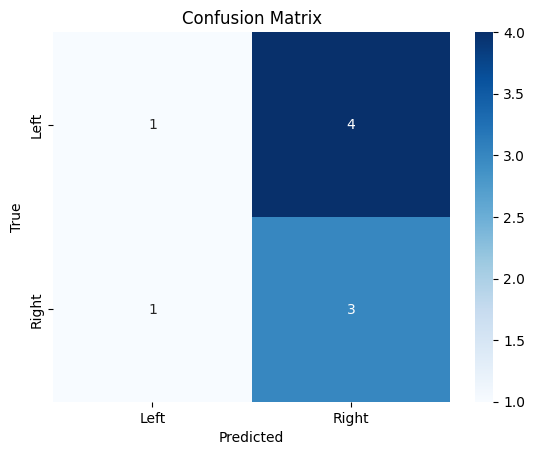

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Final Notes

This notebook provides a basic pipeline for EEG motor imagery classification:
- Signal loading
- Preprocessing
- Epoching
- Feature extraction
- Classification

You can extend this by trying:
- Different classifiers (SVM, Random Forest, CNNs)
- More subjects and runs
- Cross-validation and hyperparameter tuning

This serves as a strong starting point for real-time BCI or neuroscience research.
